In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.metrics import mutual_info_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
from collections import Counter
from IPython.display import display
import xgboost as xgb

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## Import dataset

In [5]:
data = pd.read_csv("dataset/MBA.csv")

In [6]:
data.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


## EDA

In [7]:
len(data)

6194

In [8]:
data.isnull().sum()

application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission         5194
dtype: int64

In [9]:
numerical = ["gpa", "gmat", "work_exp"]
categorical = ["gender", "international", "major", "race", "work_industry", "admission"]

### Explore numerical values

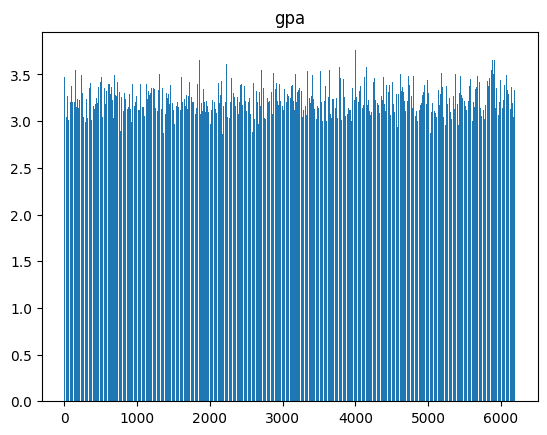

max value: 3.77
min value: 2.65
mean: 3.2507135938004517
median: 3.25


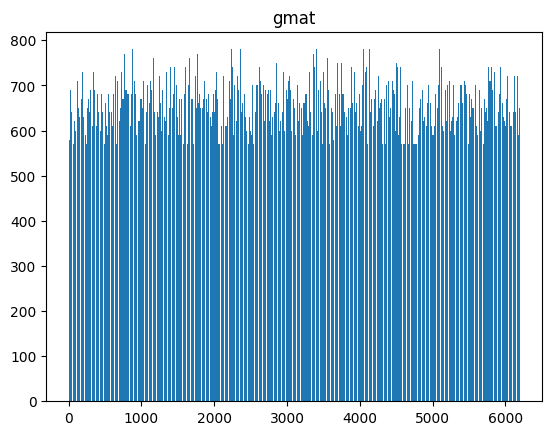

max value: 780.0
min value: 570.0
mean: 651.0929932192445
median: 650.0


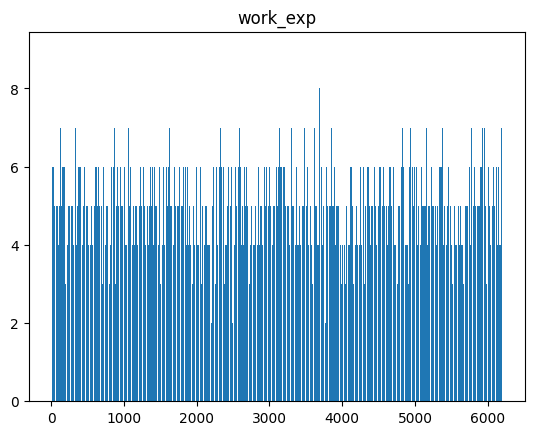

max value: 9.0
min value: 1.0
mean: 5.0169518889247655
median: 5.0


In [10]:
for category in numerical:
    plt.bar(data.application_id, data[category])
    plt.title(category)
    plt.show()
    print(f"max value: {np.max(data[category])}")
    print(f"min value: {np.min(data[category])}")
    print(f"mean: {data[category].mean()}")
    print(f"median: {data[category].median()}")

Text(0.5, 1.0, 'GPA distribution')

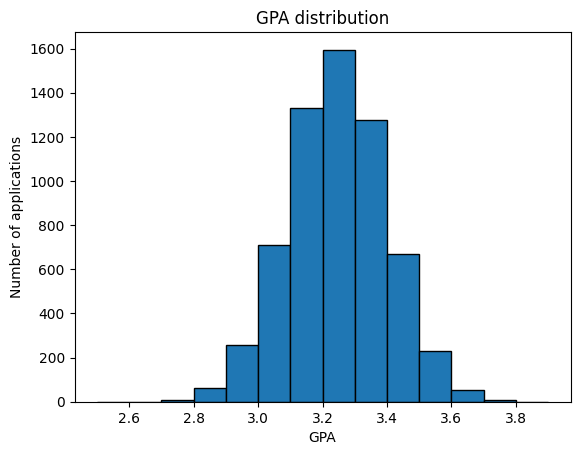

In [11]:
bins = np.arange(2.5, 4, 0.10)
plt.hist(data.gpa, bins=bins, edgecolor='black')
plt.xlabel('GPA')
plt.ylabel('Number of applications')
plt.title("GPA distribution")

(array([ 634., 1393., 1795., 1462.,  676.,  234.]),
 array([550., 590., 630., 670., 710., 750., 790.]),
 <BarContainer object of 6 artists>)

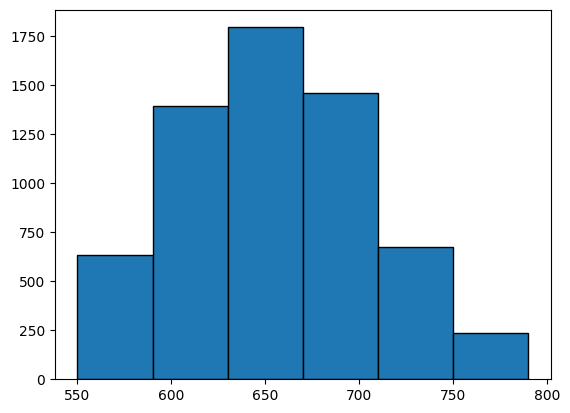

In [12]:
bins = np.arange(550, 800, 40)
plt.hist(data.gmat, bins=bins, edgecolor='black')

Text(0.5, 1.0, 'Work experience distribution')

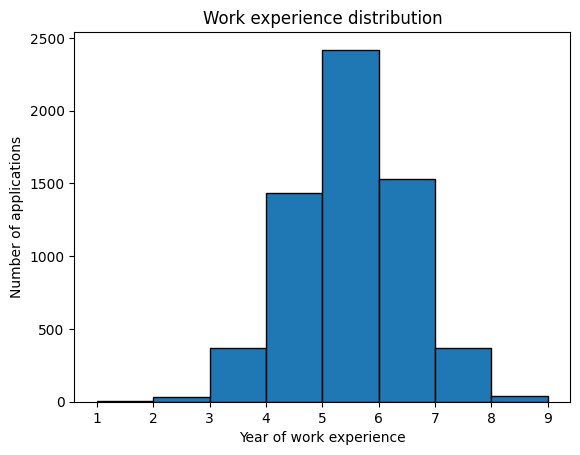

In [13]:
bins = np.arange(1, 10, 1)
plt.hist(data.work_exp, bins=bins, edgecolor='black')
plt.xlabel('Year of work experience')
plt.ylabel('Number of applications')
plt.title("Work experience distribution")

### Explore categorical values

In [14]:
data[categorical].nunique()

gender            2
international     2
major             3
race              5
work_industry    14
admission         2
dtype: int64

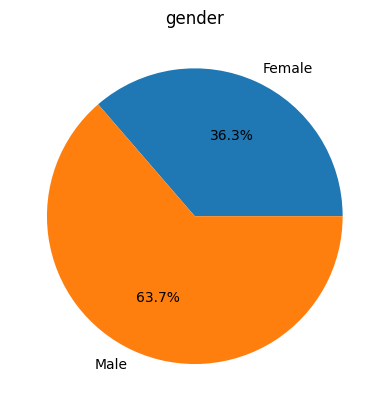

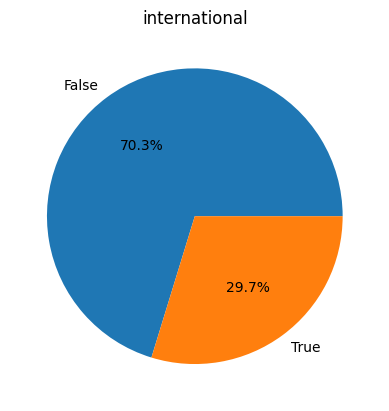

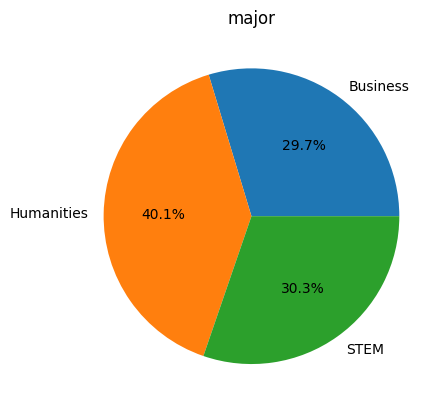

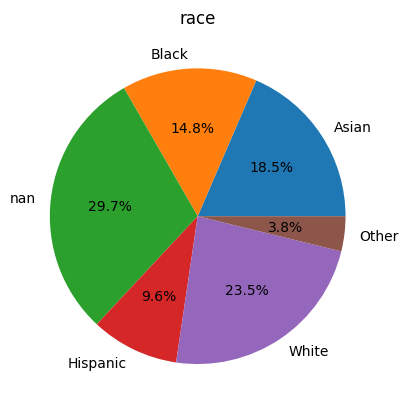

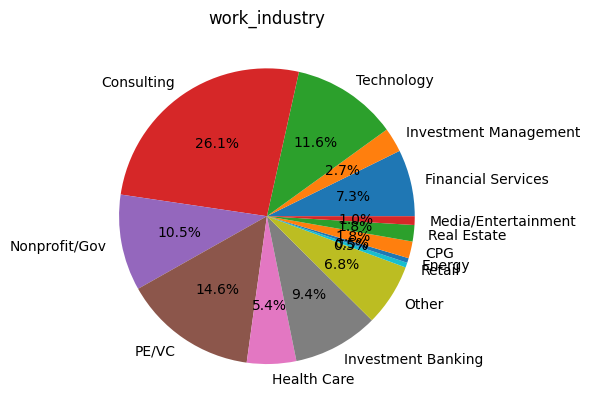

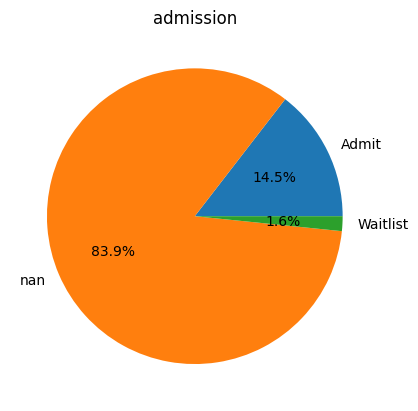

In [15]:
for category in categorical:
    counts_column = Counter(data[category])
    labels = list(counts_column.keys())
    values = list(counts_column.values())
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(category)
    plt.show()

### Prepare admission column

for training and evaluational purposes "Waitlist" in the admission column will be replaced by "Admit"

In [16]:
data.fillna(value={'race':  "Unknown"}, inplace=True)

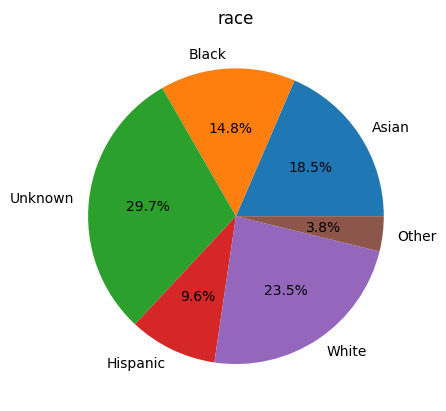

In [17]:
counts_column = Counter(data["race"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("race")
plt.show()

In [18]:
data.loc[data["admission"] == "Waitlist", "admission"] = "Admit"

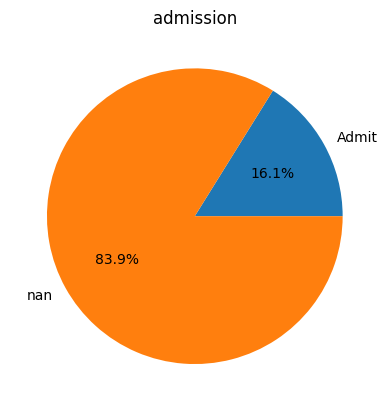

In [19]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

In [20]:
data["admission"] = (data["admission"] == "Admit").astype(int)

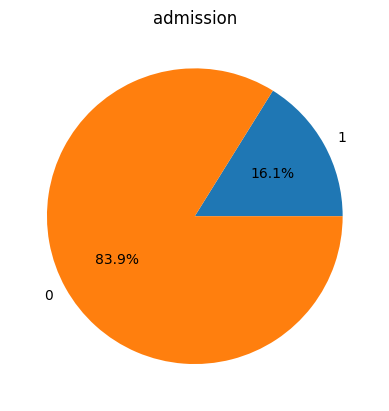

In [21]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

## Feature importance

In [22]:
categorical = ["gender", "international", "major", "race", "work_industry"]

In [23]:
overall_admision = data.admission.mean()
overall_admision

np.float64(0.16144656118824668)

In [24]:
for category in categorical:
    print(category)
    data_category = data.groupby(category).admission.agg(mean='mean', count='count')
    data_category['difference'] = data_category['mean'] - overall_admision
    data_category['risk_ratio'] = data_category['mean'] / overall_admision
    display(data_category)
    print()

gender


,mean,count,difference,risk_ratio
gender,,,,
Female,0.222124,2251,0.060677,1.375833
Male,0.126807,3943,-0.034640,0.785443



international


,mean,count,difference,risk_ratio
international,,,,
False,0.159007,4352,-0.002439,0.984892
True,0.167210,1842,0.005763,1.035696



major


,mean,count,difference,risk_ratio
major,,,,
Business,0.158868,1838,-0.002578,0.984030
Humanities,0.164450,2481,0.003003,1.018602
STEM,0.160000,1875,-0.001447,0.991040



race


,mean,count,difference,risk_ratio
race,,,,
Asian,0.184830,1147,0.023383,1.144837
Black,0.098253,916,-0.063193,0.608581
Hispanic,0.117450,596,-0.043997,0.727483
Other,0.210970,237,0.049524,1.306751
Unknown,0.167210,1842,0.005763,1.035696
White,0.185440,1456,0.023993,1.148613



work_industry


,mean,count,difference,risk_ratio
work_industry,,,,
CPG,0.184211,114,0.022764,1.141000
Consulting,0.158740,1619,-0.002707,0.983235
Energy,0.093750,32,-0.067697,0.580688
Financial Services,0.210643,451,0.049196,1.304723
Health Care,0.143713,334,-0.017734,0.890156
Investment Banking,0.155172,580,-0.006274,0.961138
Investment Management,0.222892,166,0.061445,1.380590
Media/Entertainment,0.152542,59,-0.008904,0.944847
Nonprofit/Gov,0.150538,651,-0.010909,0.932430


In [25]:
data[categorical].apply(lambda x: mutual_info_score(x, data.admission)).sort_values()

major            0.000023
international    0.000052
work_industry    0.001364
race             0.004419
gender           0.007527
dtype: float64

In [26]:
data[numerical].corrwith(data.admission).sort_values()

work_exp    0.006821
gpa         0.289618
gmat        0.353645
dtype: float64

## KFold

In [27]:
def split_train_val(full_data, train_idx, val_idx):
    data_train = full_data.iloc[train_idx]
    data_val = full_data.iloc[val_idx]
    y_train = data_train.admission.values
    y_val = data_val.admission.values
    
    del data_train["admission"]
    del data_val["admission"]
    return data_train, data_val, y_train, y_val

## Split data

In [28]:
data_full_train, data_test = train_test_split(data, test_size=0.2)
data_train, data_val = train_test_split(data_full_train, test_size=0.25)

In [29]:
print(f"train: {len(data_train)}, val: {len(data_val)}, test: {len(data_test)}")

train: 3716, val: 1239, test: 1239


In [30]:
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [31]:
y_train = data_train.admission.values
y_val = data_val.admission.values
y_test = data_test.admission.values

In [32]:
del data_train["admission"]
del data_val["admission"]
del data_test["admission"]

## Features ROC AUC

gpa: 0.7396933818790421


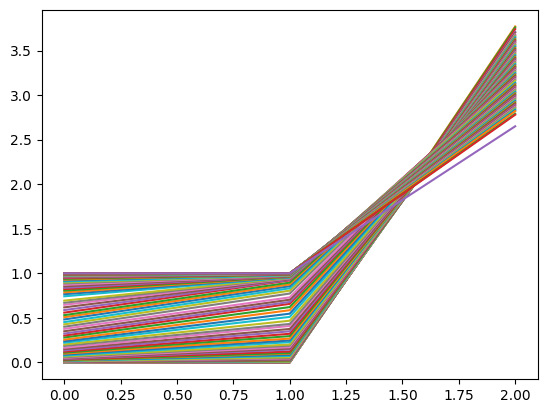

gmat: 0.7822602573308423


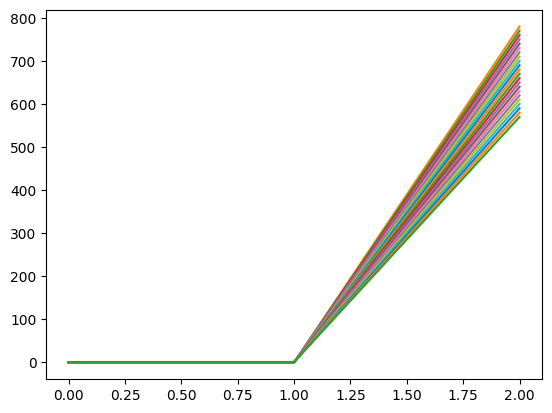

work_exp: 0.5104261435402313


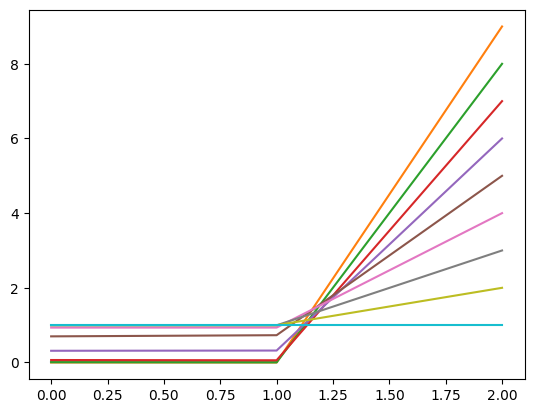

In [33]:
for col in numerical:
    auc = roc_auc_score(data_full_train.admission, data_full_train[col])
    if auc < 0.5:
        auc = roc_auc_score(data_full_train.admission, -data_full_train[col])
    print(f"{col}: {auc}")
    plt.plot(roc_curve(data_full_train.admission, data_full_train[col]))
    plt.show()

In [34]:
features = ["gender", "gpa", "race", "gmat", "work_industry"]

## Train logistic regression

In [35]:
kfold = KFold(n_splits=5, shuffle=True)

In [36]:
dv = DictVectorizer(sparse=True)

In [37]:
c_values = [0.0000001, 0.00001, 0.001, 0.1, 1, 5, 10, 100]

In [38]:
def train_model(c, features):
    scores = []
    for train_idx, val_idx in kfold.split(data_full_train):
        data_train, data_val, y_train, y_val = split_train_val(data_full_train, train_idx, val_idx)
    
        train_dict = data_train[features].to_dict(orient='records')
        train_X = dv.fit_transform(train_dict)
    
        model = LogisticRegression(solver='liblinear', C=c)
        model.fit(train_X, y_train)
        
        val_dict = data_val[features].to_dict(orient='records')
        val_X = dv.fit_transform(val_dict)
        y_pred = model.predict_proba(val_X)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))
    print(f"c={c}")
    m = np.mean(scores)
    s = np.std(scores)
    print(f"mean: {m}, std: {s}")
    return m, s

#### let's try different values of c

In [39]:
for c in c_values:
    train_model(c, features)

c=1e-07
mean: 0.22213549212281158, std: 0.017121935613233812
c=1e-05
mean: 0.222357533977842, std: 0.010895920795051866
c=0.001
mean: 0.33523049308394015, std: 0.020145107943485455
c=0.1
mean: 0.7357103863960075, std: 0.011058718277042244
c=1
mean: 0.7989359223025898, std: 0.021995035724702475
c=5
mean: 0.8133494483367525, std: 0.021521503687873096
c=10
mean: 0.8135631611462586, std: 0.0083204871478176
c=100
mean: 0.814099608254671, std: 0.023097201593944766


In [40]:
d = {}
for c in range(10, 101, 10):
    m, s = train_model(c, features)
    d[c] = {"mean": m, "std": s}

c=10
mean: 0.813663090551735, std: 0.023589762361643913
c=20
mean: 0.8153194205984343, std: 0.00391555037863048
c=30
mean: 0.8156340347977803, std: 0.016935956159713692
c=40
mean: 0.8146251975544955, std: 0.007817718167534356
c=50
mean: 0.8140249091554022, std: 0.00450849803669407
c=60
mean: 0.8156944735411692, std: 0.012356172695740616
c=70
mean: 0.8167121170348365, std: 0.023635638805887177
c=80
mean: 0.8157805733669345, std: 0.0060087558053513535
c=90
mean: 0.8161730245911298, std: 0.016147900417396367
c=100
mean: 0.8137049758457859, std: 0.01483695427823747


In [41]:
sorted_d = dict(sorted(d.items(), key=lambda item: item[1]["mean"], reverse=True))
sorted_d

{70: {'mean': np.float64(0.8167121170348365),
  'std': np.float64(0.023635638805887177)},
 90: {'mean': np.float64(0.8161730245911298),
  'std': np.float64(0.016147900417396367)},
 80: {'mean': np.float64(0.8157805733669345),
  'std': np.float64(0.0060087558053513535)},
 60: {'mean': np.float64(0.8156944735411692),
  'std': np.float64(0.012356172695740616)},
 30: {'mean': np.float64(0.8156340347977803),
  'std': np.float64(0.016935956159713692)},
 20: {'mean': np.float64(0.8153194205984343),
  'std': np.float64(0.00391555037863048)},
 40: {'mean': np.float64(0.8146251975544955),
  'std': np.float64(0.007817718167534356)},
 50: {'mean': np.float64(0.8140249091554022),
  'std': np.float64(0.00450849803669407)},
 100: {'mean': np.float64(0.8137049758457859),
  'std': np.float64(0.01483695427823747)},
 10: {'mean': np.float64(0.813663090551735),
  'std': np.float64(0.023589762361643913)}}

In [42]:
sorted_d[10]

{'mean': np.float64(0.813663090551735),
 'std': np.float64(0.023589762361643913)}

In [44]:
d = {}
for c in c_values:
    m, s = train_model(c, categorical+numerical)
    d[c] = {"mean": m, "std": s}

c=1e-07
mean: 0.21859363327211487, std: 0.014465256012040876
c=1e-05
mean: 0.21931148225620162, std: 0.010270913316740909
c=0.001
mean: 0.4352442640835391, std: 0.008457356299019034
c=0.1
mean: 0.7397381465767391, std: 0.008854032675571258
c=1
mean: 0.8040009806440025, std: 0.015580067383595235
c=5
mean: 0.8126951710968306, std: 0.007796394210009467
c=10
mean: 0.8144809933300108, std: 0.006058754536855878
c=100
mean: 0.8116471091620948, std: 0.010702360317164943


In [46]:
d = {}
for c in range(5, 101, 5):
    m, s = train_model(c, features)
    d[c] = {"mean": m, "std": s}

c=5
mean: 0.8152258731727546, std: 0.004637761869245898
c=10
mean: 0.8126545564371289, std: 0.0123828457783328
c=15
mean: 0.8151812483103814, std: 0.015314427772586833
c=20
mean: 0.8154494658159562, std: 0.0133062782078706
c=25
mean: 0.8150516830711224, std: 0.020861808556464488
c=30
mean: 0.813879702737416, std: 0.008380666129257358
c=35
mean: 0.8153188050273228, std: 0.01910692624589743
c=40
mean: 0.8163158292467122, std: 0.023368608238035573
c=45
mean: 0.8163429015678183, std: 0.004747066804672835
c=50
mean: 0.8160254972599738, std: 0.013496711254450932
c=55
mean: 0.8152640513841497, std: 0.013930455984075373
c=60
mean: 0.8165368324529592, std: 0.013219605468778017
c=65
mean: 0.8165321823902163, std: 0.010910286212701683
c=70
mean: 0.8150747765057094, std: 0.018007901944195367
c=75
mean: 0.8142378477047381, std: 0.006804356590254016
c=80
mean: 0.818123809943336, std: 0.009852162068869215
c=85
mean: 0.8118733197728796, std: 0.015711447596336588
c=90
mean: 0.8144731004110269, std: 0.0

In [47]:
sorted_d = dict(sorted(d.items(), key=lambda item: item[1]["mean"], reverse=True))
sorted_d

{80: {'mean': np.float64(0.818123809943336),
  'std': np.float64(0.009852162068869215)},
 100: {'mean': np.float64(0.8169101717473554),
  'std': np.float64(0.012872734282923065)},
 60: {'mean': np.float64(0.8165368324529592),
  'std': np.float64(0.013219605468778017)},
 65: {'mean': np.float64(0.8165321823902163),
  'std': np.float64(0.010910286212701683)},
 45: {'mean': np.float64(0.8163429015678183),
  'std': np.float64(0.004747066804672835)},
 40: {'mean': np.float64(0.8163158292467122),
  'std': np.float64(0.023368608238035573)},
 50: {'mean': np.float64(0.8160254972599738),
  'std': np.float64(0.013496711254450932)},
 20: {'mean': np.float64(0.8154494658159562),
  'std': np.float64(0.0133062782078706)},
 35: {'mean': np.float64(0.8153188050273228),
  'std': np.float64(0.01910692624589743)},
 55: {'mean': np.float64(0.8152640513841497),
  'std': np.float64(0.013930455984075373)},
 5: {'mean': np.float64(0.8152258731727546),
  'std': np.float64(0.004637761869245898)},
 15: {'mean': 

#### train final logistic regression models

In [48]:
full_model_lg_75 = LogisticRegression(solver='liblinear', C=75)

In [49]:
full_train_dict = data_train.to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dict)

full_model_lg_75.fit(X_full_train, y_train)

LogisticRegression(C=75, solver='liblinear')

In [50]:
full_test_dict = data_test.to_dict(orient='records')
X_full_test = dv.fit_transform(full_test_dict)

y_pred = full_model_lg_75.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.7297421159666593)

As we can see from teh roc auc the model overfits to the training data, so we'll train a new model on a smaller number of features

In [51]:
train_dict = data_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = data_val[features].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

test_dict = data_test[features].to_dict(orient='records')
X_test = dv.fit_transform(test_dict)

In [52]:
final_model_lg_75 = LogisticRegression(solver='liblinear', C=75)

In [53]:
final_model_lg_75.fit(X_train, y_train)

LogisticRegression(C=75, solver='liblinear')

In [54]:
y_pred = final_model_lg_75.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8124277953349819)

In [55]:
final_model_lg_10 = LogisticRegression(solver='liblinear', C=10)

In [56]:
final_model_lg_10.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [57]:
y_pred = final_model_lg_10.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.811654429666689)

LogisticRegression with C=75 has been the most accurate so far

## Train decision trees

In [58]:
depths = list(range(1, 21)) + list(range (25, 50, 5))
depths.append(None)

In [59]:
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)

    y_pred = tree.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print(f'{depth}: {auc}')

1: 0.7424133782483157
2: 0.813079884504331
3: 0.8200192492781521
4: 0.811655437921078
5: 0.8172786333012512
6: 0.817223291626564
7: 0.8119754571703561
8: 0.807230510105871
9: 0.7896487006737247
10: 0.7810707410972089
11: 0.7537151106833495
12: 0.7287151106833495
13: 0.7259191530317615
14: 0.7280895091434071
15: 0.7065615976900868
16: 0.6927574590952839
17: 0.6742131857555342
18: 0.6572064485081809
19: 0.659436958614052
20: 0.6422762271414821
25: 0.6220596727622715
30: 0.606104427333975
35: 0.6050481231953801
40: 0.6048195380173244
45: 0.6197690086621751
None: 0.6195452358036574


In [60]:
best_depths = [3, 4, 5]

In [61]:
min_leaves = list(range(1, 5)) + list(range(10, 31, 5)) + list(range(50, 201, 50))
min_leaves

[1, 2, 3, 4, 10, 15, 20, 25, 30, 50, 100, 150, 200]

In [62]:
scores = []
for depth in best_depths:
    print(f"depth: {depth}")
    d = {}
    for m_l in min_leaves:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=m_l)
        tree.fit(X_train, y_train)

        y_pred = tree.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        d[m_l] = auc
        scores.append((depth, m_l, auc))
    sorted_d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
    print(sorted_d)

depth: 3
{1: np.float64(0.8200192492781521), 2: np.float64(0.8200192492781521), 3: np.float64(0.8200192492781521), 4: np.float64(0.8200192492781521), 10: np.float64(0.8200192492781521), 15: np.float64(0.8200192492781521), 20: np.float64(0.8200192492781521), 25: np.float64(0.8200192492781521), 30: np.float64(0.8200192492781521), 50: np.float64(0.8200192492781521), 100: np.float64(0.8200192492781521), 200: np.float64(0.8173556304138594), 150: np.float64(0.8170668912415784)}
depth: 4
{150: np.float64(0.8197834456207892), 100: np.float64(0.8176900866217517), 10: np.float64(0.8170981713185755), 15: np.float64(0.8170981713185755), 20: np.float64(0.8170981713185755), 200: np.float64(0.8166434071222329), 25: np.float64(0.8165688161693936), 30: np.float64(0.8165688161693936), 50: np.float64(0.8163041385948027), 4: np.float64(0.8126852743022137), 1: np.float64(0.811655437921078), 2: np.float64(0.811655437921078), 3: np.float64(0.811655437921078)}
depth: 5
{150: np.float64(0.8185370548604427), 1:

best params combinations are: (max_depth: 4, min_samples_leaf: 100; max_depth: 5, min_samples_leaf: 100, max_depth: 3, min_samples_leaf: 2;)

#### train final decision trees models

In [63]:
full_tree_depth_3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [64]:
full_tree_depth_3.fit(X_full_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [65]:
y_pred = full_tree_depth_3.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8822359815537967)

In [66]:
tree_depth_3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [67]:
tree_depth_3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [68]:
y_pred = tree_depth_3.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8467279948824198)

In [69]:
tree_depth_4 = DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)

In [70]:
tree_depth_4.fit(X_full_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)

In [71]:
y_pred = tree_depth_4.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8579752141077175)

In [72]:
tree_depth_5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

In [73]:
tree_depth_5.fit(X_full_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

In [74]:
y_pred = tree_depth_5.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8571254666450252)

DecisionTreeClassifier with max_depth=4, min_samples_leaf=100 has been the most accurate so far

## Train RandomForestClassifier

In [75]:
scores = []
d = {}
for n in range(5, 201, 5):
    forest = RandomForestClassifier(n_estimators=n)
    forest.fit(X_train, y_train)

    y_pred = forest.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))
    d[n] = auc

In [76]:
n_estimators_sorted = sorted(d.items(), key=lambda item: item[1], reverse=True)
n_estimators_sorted

[(190, np.float64(0.8095933589990376)),
 (175, np.float64(0.8089773820981714)),
 (200, np.float64(0.8086838306063524)),
 (110, np.float64(0.8077983638113571)),
 (165, np.float64(0.8071727622714148)),
 (90, np.float64(0.8069754571703561)),
 (85, np.float64(0.8068407122232917)),
 (185, np.float64(0.8060298363811357)),
 (135, np.float64(0.8058253128007701)),
 (170, np.float64(0.8056929740134745)),
 (130, np.float64(0.8051997112608277)),
 (80, np.float64(0.8051804619826756)),
 (180, np.float64(0.8051106833493745)),
 (145, np.float64(0.8050794032723771)),
 (150, np.float64(0.8049326275264677)),
 (100, np.float64(0.8048676612127044)),
 (55, np.float64(0.8047425409047161)),
 (50, np.float64(0.8043960538979789)),
 (195, np.float64(0.8043912415784408)),
 (155, np.float64(0.8043431183830606)),
 (120, np.float64(0.8043142444658326)),
 (75, np.float64(0.8037848893166508)),
 (125, np.float64(0.8037656400384986)),
 (160, np.float64(0.8037295476419632)),
 (140, np.float64(0.8034744947064486)),
 (105,

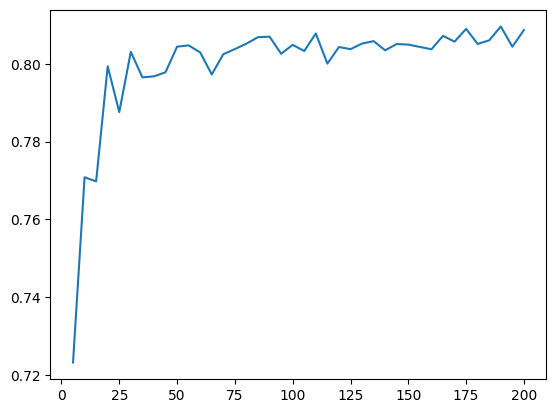

In [77]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

In [78]:
scores = []

for depth in range(5, 26, 5):
    for n in range(5, 201, 5):
        forest = RandomForestClassifier(n_estimators=n, max_depth=depth)
        forest.fit(X_train, y_train)
    
        y_pred = forest.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, n, auc))

In [79]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

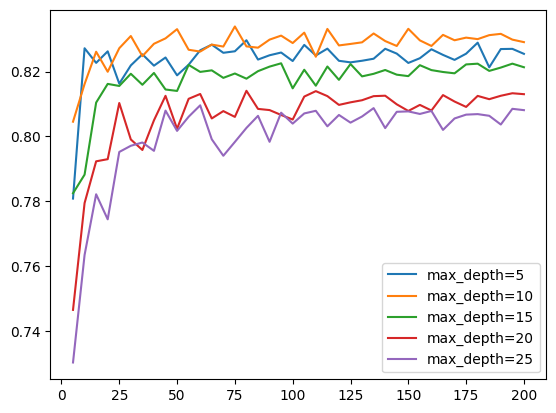

In [81]:
for depth in range(5, 26, 5):
    line_coords = df_scores[df_scores.max_depth == depth]

    plt.plot(line_coords.n_estimators, line_coords.auc, label=f'max_depth={depth}')
plt.legend()

In [82]:
best_depths = [5, 10]
min_sample_leaves = list(range(1, 5)) + list(range(10, 31, 5)) + list(range(50, 201, 50))

In [83]:
def evaluate_depth(depth, min_sample_leaves):
    scores=[]
    for m_l in min_sample_leaves:
        for n in range(5, 201, 5):
            forest = RandomForestClassifier(n_estimators=n, max_depth=depth, min_samples_leaf=m_l)
            forest.fit(X_train, y_train)
        
            y_pred = forest.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            
            scores.append((m_l, n, auc))
            df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'auc'])
    for m_l in min_sample_leaves:
        line_coords = df_scores[df_scores.min_samples_leaf == m_l]
    
        plt.plot(line_coords.n_estimators, line_coords.auc, label=f'.min_samples_leaf={m_l}')
    plt.legend()

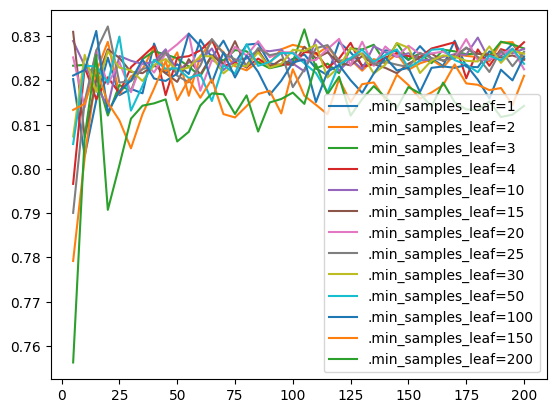

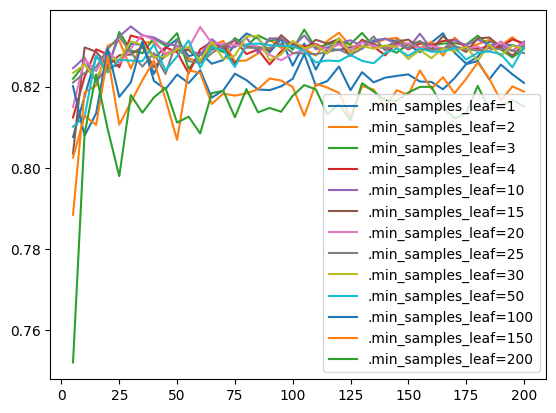

In [84]:
for depth in best_depths:
    evaluate_depth(depth, min_sample_leaves)
    plt.show()

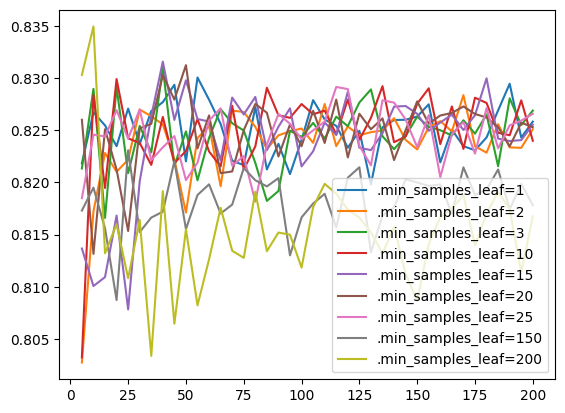

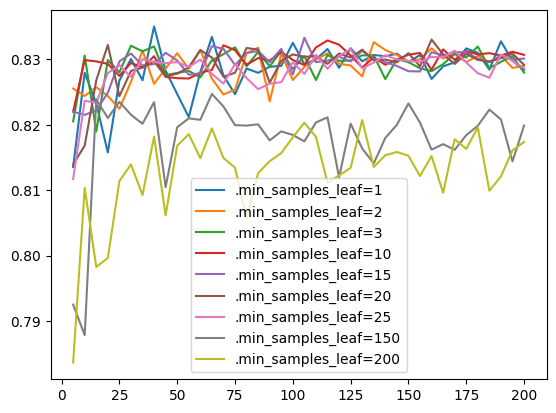

In [85]:
min_sample_leaves = [1, 2, 3, 10, 15, 20, 25, 150, 200]
for depth in best_depths:
    evaluate_depth(depth, min_sample_leaves)
    plt.show()

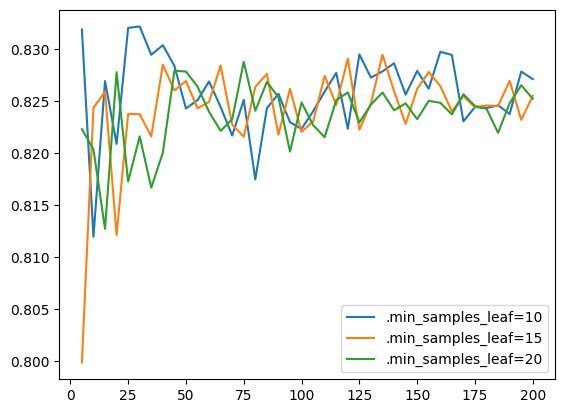

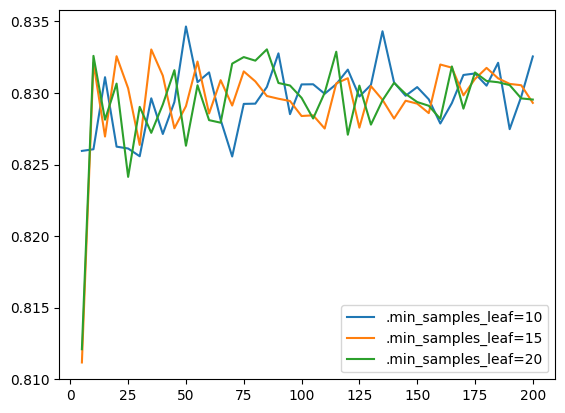

In [86]:
min_sample_leaves = [10, 15, 20]
for depth in best_depths:
    evaluate_depth(depth, min_sample_leaves)
    plt.show()

In [87]:
n_estimators = 80

#### select max_features and bootstrap

In [88]:
for depth in best_depths:
    print(f"{depth}:")
    for m_f in ("sqrt", "log2", None):
        forest = RandomForestClassifier(max_depth=5, 
                                    n_estimators=n_estimators, 
                                    min_samples_leaf=15, 
                                    max_features=m_f
                                   )
        forest.fit(X_train, y_train)
            
        y_pred = forest.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print(f"{m_f}: {auc}")

5:
sqrt: 0.828072666025024
log2: 0.8230341674687198
None: 0.8240736284889316
10:
sqrt: 0.8206183830606352
log2: 0.8271631376323387
None: 0.8245283926852742


In [89]:
for depth in best_depths:
    print(f"{depth}:")
    for b in (True, False):
        print(f"bootstrap: {b}")
        for m_f in ("sqrt", None):
            forest = RandomForestClassifier(max_depth=5, 
                                        n_estimators=n_estimators, 
                                        min_samples_leaf=15, 
                                        max_features=m_f, 
                                        bootstrap=b
                                       )
            forest.fit(X_train, y_train)
                
            y_pred = forest.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            print(f"{m_f}: {auc}")

5:
bootstrap: True
sqrt: 0.8216121270452358
None: 0.8239148219441772
bootstrap: False
sqrt: 0.8208445620789221
None: 0.815851780558229
10:
bootstrap: True
sqrt: 0.826686717998075
None: 0.8225721847930703
bootstrap: False
sqrt: 0.8246535129932627
None: 0.815851780558229


best params combinations:<br>
max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True<br>
max_depth=10, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=False

#### train final models

In [90]:
full_forest_5 = RandomForestClassifier(max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True)
full_forest_5.fit(X_full_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=15, n_estimators=80)

In [91]:
y_pred = full_forest_5.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8938149841985163)

In [92]:
forest_5 = RandomForestClassifier(max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True)
forest_5.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=15, n_estimators=80)

In [93]:
y_pred = forest_5.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.838786675195967)

In [94]:
full_forest_10 = RandomForestClassifier(max_depth=10, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=False)
full_forest_10.fit(X_full_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=15,
                       n_estimators=80)

In [95]:
y_pred = full_forest_10.predict_proba(X_full_test)[:, 1]
roc_auc_score(y_test, y_pred)

np.float64(0.8936813160583175)

RandomForestClassifier trained on the whole set of features with paramethers: max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True has been the most accurate so far

## Gradient boosting algorithm

In [96]:
def get_xgb_params(eta=0.3, max_depth=6, min_child_weight=1):
    return {
        'eta': eta, 
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        
        'objective': 'binary:logistic',
        'nthread': 8,
        
        'eval_metric': 'auc',
        'verbosity': 1,
    }

In [110]:
xgb_params = get_xgb_params()
features = list(dv.get_feature_names_out())

In [112]:
dv_full = DictVectorizer(sparse=True)

full_train_dict = data_train.to_dict(orient='records')
X_full_train = dv_full.fit_transform(full_train_dict)

full_val_dict = data_val.to_dict(orient='records')
X_full_val = dv_full.fit_transform(full_val_dict)

full_test_dict = data_test.to_dict(orient='records')
X_full_test = dv_full.fit_transform(full_test_dict)

In [116]:
full_features = list(dv_full.get_feature_names_out())

In [107]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [117]:
dtrain_full = xgb.DMatrix(X_full_train, label=y_train, feature_names=full_features)
dval_full = xgb.DMatrix(X_full_val, label=y_val, feature_names=full_features)
dtest_full = xgb.DMatrix(X_full_test, label=y_test, feature_names=full_features)

In [118]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [119]:
model_default = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=5, evals=watchlist)

[0]	train-auc:0.87131	val-auc:0.82414
[5]	train-auc:0.89030	val-auc:0.82762
[10]	train-auc:0.90088	val-auc:0.82978
[15]	train-auc:0.91405	val-auc:0.82507
[20]	train-auc:0.91970	val-auc:0.82396
[25]	train-auc:0.92750	val-auc:0.82563
[30]	train-auc:0.93739	val-auc:0.82240
[35]	train-auc:0.94579	val-auc:0.82061
[40]	train-auc:0.95235	val-auc:0.81514
[45]	train-auc:0.95734	val-auc:0.81295
[50]	train-auc:0.96266	val-auc:0.81284
[55]	train-auc:0.96676	val-auc:0.81153
[60]	train-auc:0.96875	val-auc:0.81224
[65]	train-auc:0.96967	val-auc:0.81259
[70]	train-auc:0.97144	val-auc:0.81173
[75]	train-auc:0.97324	val-auc:0.81210
[80]	train-auc:0.97482	val-auc:0.81231
[85]	train-auc:0.97573	val-auc:0.81269
[90]	train-auc:0.97831	val-auc:0.81255
[95]	train-auc:0.97978	val-auc:0.80988
[100]	train-auc:0.98146	val-auc:0.80760
[105]	train-auc:0.98279	val-auc:0.80772
[110]	train-auc:0.98398	val-auc:0.80709
[115]	train-auc:0.98480	val-auc:0.80696
[120]	train-auc:0.98579	val-auc:0.80603
[125]	train-auc:0.9873

In [120]:
watchlist_full = [(dtrain_full, 'train'), (dval_full, 'val')]

In [135]:
%%capture output
model_default_full = xgb.train(xgb_params, dtrain_full, num_boost_round=200, 
                               verbose_eval=5, evals=watchlist_full)

In [136]:
def parse_xgb_res(output):
    results = []

    for line in output.strip().split('\n'):
        num, train_line, val_line = line.split('\t')

        n = int(num.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((n, train, val))
    
    columns = ['iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [137]:
data_score = parse_xgb_res(output.stdout)

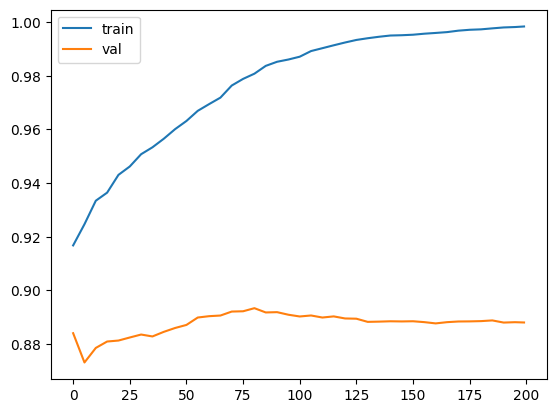

In [138]:
plt.plot(data_score.iter, data_score.train_auc, label='train')
plt.plot(data_score.iter, data_score.val_auc, label='val')
plt.legend()

In [129]:
import io

In [131]:
from contextlib import redirect_stdout

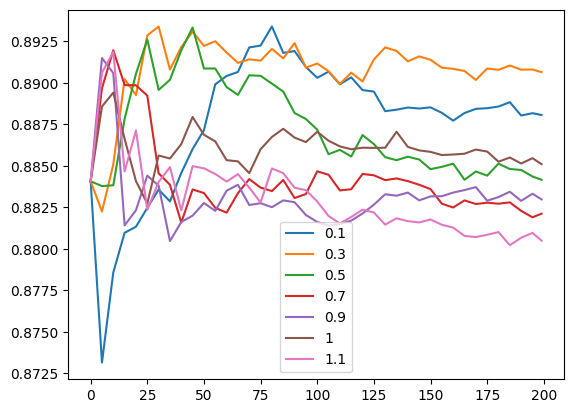

In [151]:
for eta in [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.1]:
    xgb_params = get_xgb_params(eta=eta)
    with io.StringIO() as buf, redirect_stdout(buf):
        model_full = xgb.train(xgb_params, dtrain_full, num_boost_round=200, 
                                       verbose_eval=5, evals=watchlist_full)
        output = buf.getvalue()
    data_score = parse_xgb_res(output)
    plt.plot(data_score.iter, data_score.val_auc, label=f'{eta}')
plt.legend()

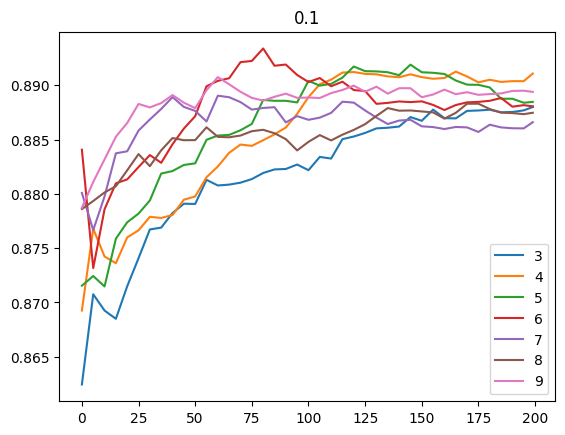

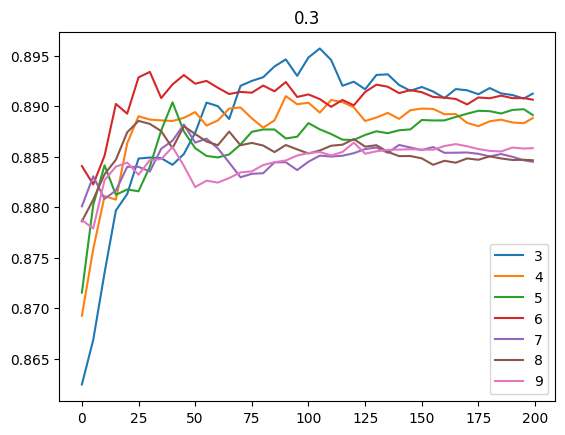

In [152]:
for eta in [0.1, 0.3]:
    for depth in range(3, 10):
        xgb_params = get_xgb_params(eta=eta, max_depth=depth)
        with io.StringIO() as buf, redirect_stdout(buf):
            model_full = xgb.train(xgb_params, dtrain_full, num_boost_round=200, 
                                           verbose_eval=5, evals=watchlist_full)
            output = buf.getvalue()
        data_score = parse_xgb_res(output)
        plt.plot(data_score.iter, data_score.val_auc, label=f'{depth}')
    plt.legend()
    plt.title(eta)
    plt.show()

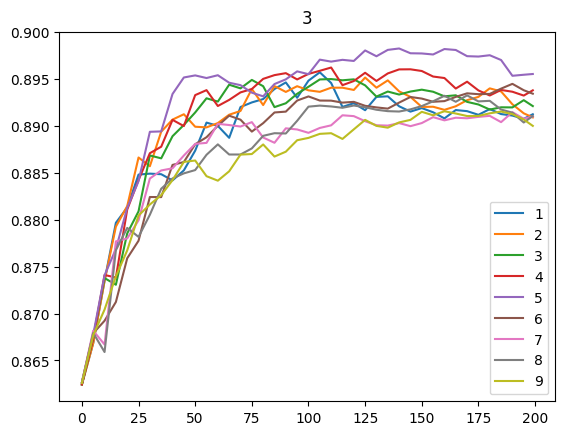

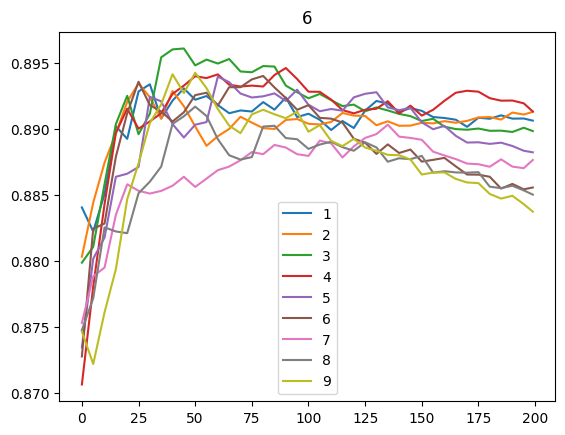

In [153]:
eta = 0.3
for depth in [3, 6]:
    for weight in range(1, 10):
        xgb_params = get_xgb_params(eta=eta, max_depth=depth, min_child_weight=weight)
        with io.StringIO() as buf, redirect_stdout(buf):
            model_full = xgb.train(xgb_params, dtrain_full, num_boost_round=200, 
                                           verbose_eval=5, evals=watchlist_full)
            output = buf.getvalue()
        data_score = parse_xgb_res(output)
        plt.plot(data_score.iter, data_score.val_auc, label=f'{weight}')
    plt.legend()
    plt.title(depth)
    plt.show()

We will train with best params combination: eta=0.3, max_depth=3, min_child_weight=5

In [154]:
xgb_params = get_xgb_params(eta=0.3, max_depth=3, min_child_weight=5)

In [159]:
model_xgb = xgb.train(xgb_params, dtrain_full, num_boost_round=130, 
                                           verbose_eval=5, evals=watchlist_full)

[0]	train-auc:0.87827	val-auc:0.86265
[5]	train-auc:0.89497	val-auc:0.86775
[10]	train-auc:0.90594	val-auc:0.87407
[15]	train-auc:0.91297	val-auc:0.87688
[20]	train-auc:0.91790	val-auc:0.88126
[25]	train-auc:0.92384	val-auc:0.88411
[30]	train-auc:0.92995	val-auc:0.88937
[35]	train-auc:0.93437	val-auc:0.88941
[40]	train-auc:0.93647	val-auc:0.89340
[45]	train-auc:0.94062	val-auc:0.89516
[50]	train-auc:0.94387	val-auc:0.89538
[55]	train-auc:0.94601	val-auc:0.89510
[60]	train-auc:0.94899	val-auc:0.89540
[65]	train-auc:0.95032	val-auc:0.89460
[70]	train-auc:0.95089	val-auc:0.89434
[75]	train-auc:0.95169	val-auc:0.89354
[80]	train-auc:0.95245	val-auc:0.89315
[85]	train-auc:0.95469	val-auc:0.89446
[90]	train-auc:0.95631	val-auc:0.89496
[95]	train-auc:0.95797	val-auc:0.89581
[100]	train-auc:0.95966	val-auc:0.89551
[105]	train-auc:0.96109	val-auc:0.89706
[110]	train-auc:0.96300	val-auc:0.89685
[115]	train-auc:0.96410	val-auc:0.89704
[120]	train-auc:0.96460	val-auc:0.89692
[125]	train-auc:0.9653

In [162]:
y_pred = model_xgb.predict(dtest_full)

In [163]:
roc_auc_score(y_test, y_pred)

np.float64(0.8887212732845127)

Despite gradient boost (eta=0.3, max_depth=3, min_child_weight=5) showing a pretty good accuracy, RandomForestClassifier(max_depth=5, n_estimators=80, min_samples_leaf=15, max_features="sqrt", bootstrap=True) trained on the whole set of features with paramethers remains the most accurate model